CUSTOMERS CATEGORY BASED ON : 1. payment_value , orders , order time 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

master_df = pd.read_csv('outputs/cleaned_olist_data.csv')

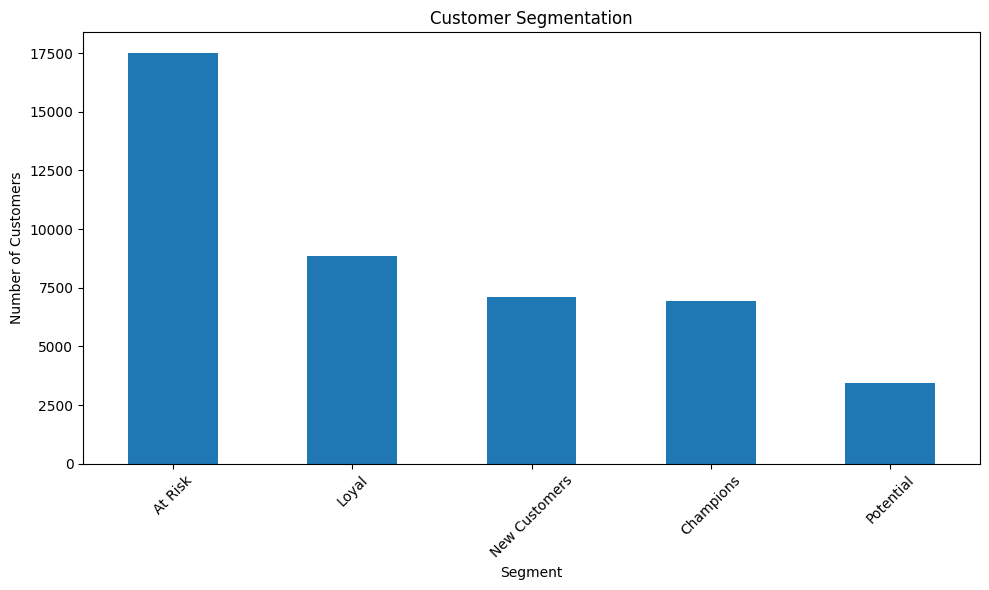

In [3]:
# RFM Analysis
master_df['order_purchase_timestamp'] = pd.to_datetime(master_df['order_purchase_timestamp'])
analysis_date = master_df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

rfm = master_df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (analysis_date - x.max()).days,  # Recency
    'order_id': 'count',  # Frequency
    'payment_value': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

# Create RFM scores
rfm['r_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['m_score'] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)

# Segment customers
def segment_customers(row):
    if row['r_score'] >= 4 and row['f_score'] >= 4:
        return 'Champions'
    elif row['r_score'] >= 3 and row['f_score'] >= 3:
        return 'Loyal'
    elif row['r_score'] >= 4 and row['f_score'] <= 2:
        return 'New Customers'
    elif row['r_score'] <= 2:
        return 'At Risk'
    else:
        return 'Potential'

rfm['segment'] = rfm.apply(segment_customers, axis=1)

# Visualize segments
plt.figure(figsize=(10, 6))
rfm['segment'].value_counts().plot(kind='bar')
plt.title('Customer Segmentation')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/visualizations/customer_segments.png')
plt.show()

# Save RFM data
# rfm.to_csv('rfm_analysis.csv', index=False)